In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
from common.calculate_volatility import calculate_variance

import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [121]:
# data 기초 전처리
data = pd.read_csv('../data/GSPC.csv')
data = data.set_index('Date')

# 인덱스를 datetime으로 변경
data.index = pd.to_datetime(data.index)

# test 셋과 train 셋으로 나누기
split_date= dt.datetime(2011,12,5)
train_data = data[data.index<split_date]
test_data = data[data.index>=split_date]

# log 수익률 column 추가
train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
train_data_return = train_data['log_price_return'].dropna()

test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)
test_data_return = test_data['log_price_return'].dropna()


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_46806/536290991.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_price_return'] = np.log(train_data['Adj Close']).diff(1)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_46806/536290991.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['log_price_return'] = np.log(test_data['Adj Close']).diff(1)


In [122]:
# dataset 만들기
# train
train_data_set = pd.DataFrame()
var = calculate_variance(train_data_return)
train_data_set['rv'] = np.sqrt(var)
train_data_set['log_return'] = train_data_return
# test
test_data_set = pd.DataFrame()
var = calculate_variance(test_data_return)
test_data_set['rv'] = np.sqrt(var)
test_data_set['log_return'] = test_data_return


In [123]:
# scaling 
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_data_minmax = scaler_minmax.fit_transform(train_data_set)
test_data_minmax = scaler_minmax.transform(test_data_set)

# 정규화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_data_df = pd.DataFrame(train_data_minmax, index=train_data_set.index,columns=train_data_set.columns)
test_data_df = pd.DataFrame(test_data_minmax, index=test_data_set.index,columns=test_data_set.columns)

In [124]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

SVR_parameters = [{"C" : [0.1,0.2,0.3,1,2,3], "gamma" : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], "nu": [0.1,0.2,0.3,0.4,0.5]}]
tscv = TimeSeriesSplit(n_splits=5)

#모델 생성
svr_rbf = NuSVR(kernel='rbf')

#RMSE 평가 지표 함수 
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred,squared=False)), greater_is_better=False)

grid_search = GridSearchCV(estimator=svr_rbf, param_grid=SVR_parameters,scoring=rmse_scorer, cv=tscv)

In [125]:
y_rbf = grid_search.fit(train_data_df[:-1].values,train_data_set[1:]['rv'].values.flatten())
predicted_y = y_rbf.predict(test_data_df[:-1].values)

In [126]:
# from sklearn.metrics import make_scorer, mean_squared_error
# from sklearn.svm import NuSVR
# 
# svr_rbf = NuSVR(kernel='rbf',C=0.2,gamma=0.5, nu=0.5)
# y_rbf = svr_rbf.fit(train_data_df[:-1].values,train_data_set[1:]['rv'].values.flatten())
# predicted_y = y_rbf.predict(test_data_df[:-1].values)

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

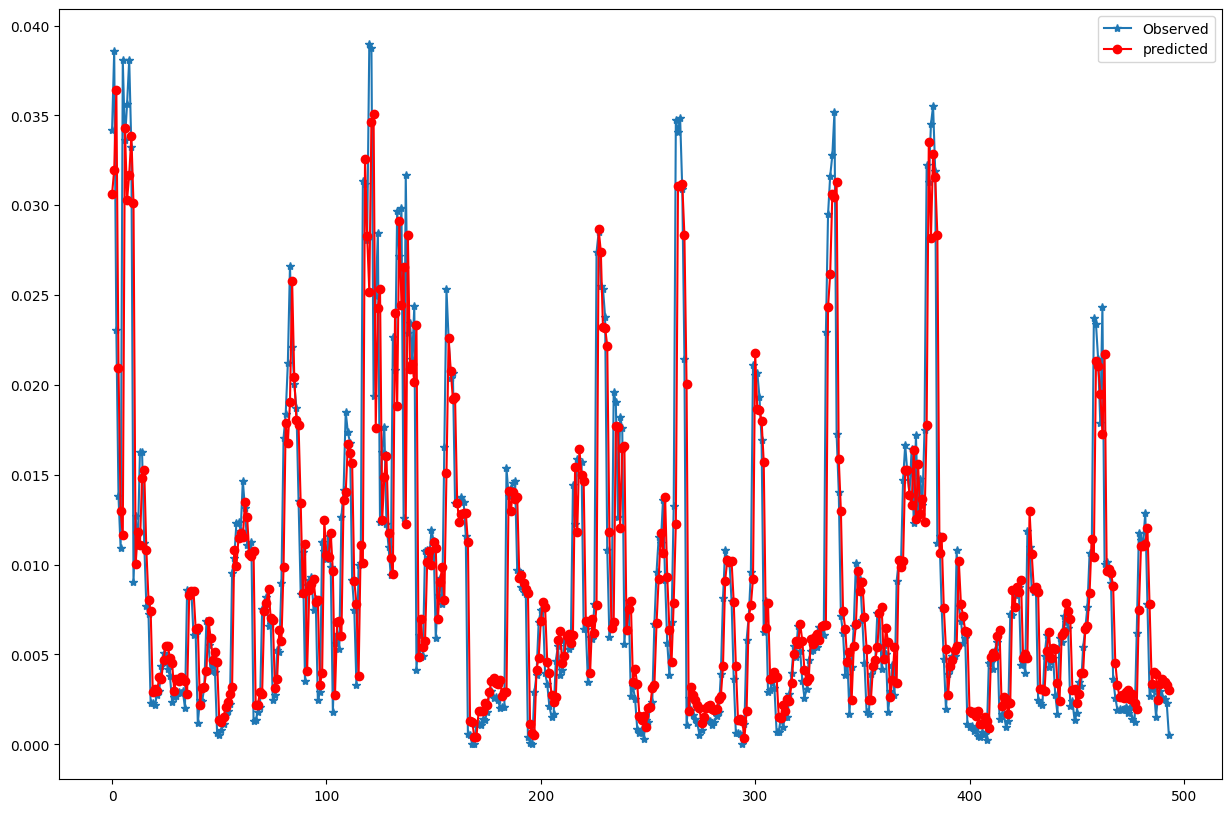

In [127]:
rv_train = pd.DataFrame(train_data_set['rv'])
scaler_result = MinMaxScaler()
scaler_result.fit(rv_train)

df_y = scaler_result.transform(predicted_y.reshape(-1,1))

plt.figure(figsize=(15,10))
plt.plot(test_data_df[1:].rv.values**2,marker='*', label = "Observed")
plt.plot(df_y**2,marker='o', label='predicted', color='red')

plt.legend()

In [128]:
mean_squared_error(df_y,test_data_df[1:].rv.values,squared=False)

0.02208302543637222

In [129]:
grid_search.best_params_

{'C': 0.2, 'gamma': 0.5, 'nu': 0.5}